Для воспроизводимости кода установим определенную версию tensorflow и keras

In [1]:
!pip install -q tensorflow==2.1

     |████████████████████████████████| 421.8 MB 26 kB/s 
     |████████████████████████████████| 3.8 MB 49.3 MB/s 
     |████████████████████████████████| 448 kB 55.7 MB/s 
     |████████████████████████████████| 50 kB 7.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.


In [2]:
!pip install keras==2.3.1

     |████████████████████████████████| 377 kB 6.9 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.1.0
We are using Keras 2.2.4-tf


In [5]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2ef87a38-9166-020d-498f-db596f653389)


In [7]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Sun Jan 30 09:52:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W /  70W |    104MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# MNIST

In [8]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [9]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


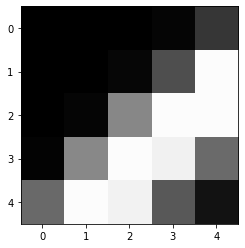

Пример картинки:


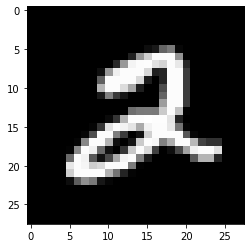

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [10]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

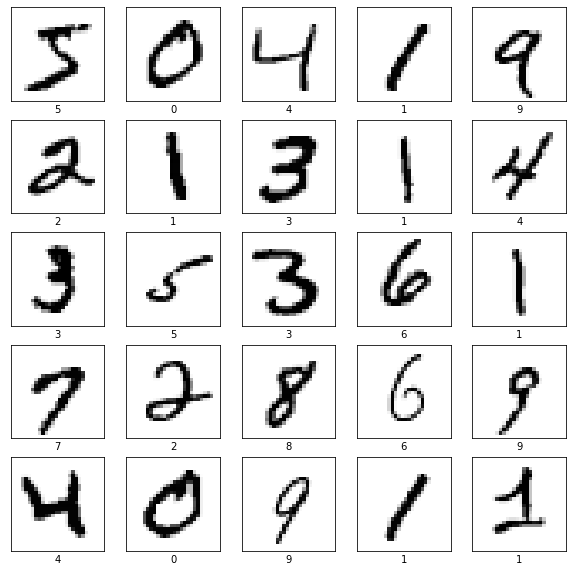

In [11]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Data

In [12]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [13]:
# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

In [14]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


# Собираем модель

Построим простой Multi layer Perceptron (MLP) классификатор в Keras (по аналогии со знакомым нам уже MLPClassifier из sklearn)

<img src="https://cdn-images-1.medium.com/max/1600/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" width="500">


Сначала надо будет посчитать логиты (logit, линейное преобразование) $z_k$ для каждого класса: $$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

А затем превратить логиты $z_k$ в вероятности $p_k$ при помощи функции softmax: $$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

Мы будем использовать cross-entropy для минимизации ошибки: $$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$

где $$ [x]=\begin{cases} 1, \quad \text{если $x$ истина} \\ 0, \quad \text{иначе} \end{cases} $$

Минимизация cross-entropy двигает $p_k$ в сторону 1 когда $y = k$, что как раз мы и хотим.


In [ ]:
clear_session()

In [15]:
# Архитектура сети
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [ ]:
history = model.fit(
                    x_train_float, 
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 59us/sample - loss: 0.3003 - accuracy: 0.9081 - val_loss: 0.1794 - val_accuracy: 0.9450
Epoch 2/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.1412 - accuracy: 0.9570 - val_loss: 0.1191 - val_accuracy: 0.9629
Epoch 3/10
60000/60000 [==============================] - 3s 52us/sample - loss: 0.1049 - accuracy: 0.9670 - val_loss: 0.1063 - val_accuracy: 0.9645
Epoch 4/10
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0840 - accuracy: 0.9739 - val_loss: 0.0945 - val_accuracy: 0.9703
Epoch 5/10
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0732 - accuracy: 0.9765 - val_loss: 0.1058 - val_accuracy: 0.9669
Epoch 6/10
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0609 - accuracy: 0.9798 - val_loss: 0.1227 - val_accuracy: 0.9617
Epoch 7/10
60000/60000 [==============================] 

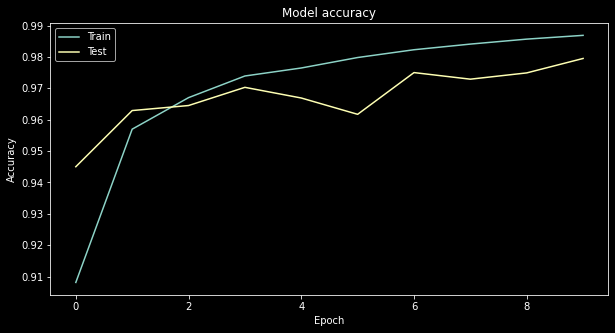

In [ ]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

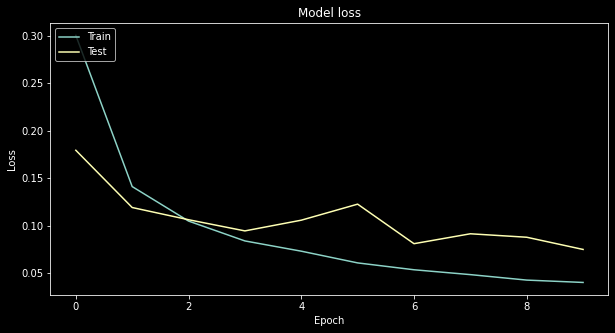

In [ ]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.predict(x_val_float)

array([[3.7976780e-10, 1.4765423e-06, 1.0373625e-06, ..., 9.9997568e-01,
        2.8929936e-09, 1.1557075e-06],
       [4.6935046e-11, 1.5245649e-07, 9.9998355e-01, ..., 7.1067874e-12,
        1.7328855e-08, 3.7978248e-17],
       [2.9848115e-07, 9.9863905e-01, 8.8465272e-04, ..., 4.6329878e-04,
        1.6476364e-06, 9.9760364e-08],
       ...,
       [1.0953818e-14, 1.2799708e-12, 2.5284492e-12, ..., 2.2487969e-09,
        4.3461439e-09, 1.1370821e-08],
       [5.6421749e-07, 1.1316542e-14, 2.9154648e-09, ..., 1.6111365e-08,
        1.0832634e-03, 4.2164494e-11],
       [1.4757423e-09, 5.9035822e-13, 8.4996798e-10, ..., 1.7336293e-14,
        1.1791868e-08, 1.4659207e-09]], dtype=float32)

In [ ]:
model.predict_classes(x_val_float)

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
# аналогично
np.argmax(model.predict(x_val_float), axis = 1)

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
predicts = model.predict_classes(x_val_float)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

Test Accuracy:  0.9795
